# IMPLÉMENTER UN MODÈLE DE SCORING


## Notebook de modélisation

Les 2 premiers notebooks nous ont permis d'explorer les données, de les nettoyer et de sélectionner les features les plus pertinentes.

Dans ce notebook de modélisation, nous allons commencer par effectuer le preprocessing afin de préparer les données pour la modélisation.

Nous utiliserons ensuite un pipeline qui nous permettra de tester :

- deux façons de rééquilibrer la variable cible (en retranchant des données provenant des caractéristiques prédictrices, ou en créant des données synthétiques basées sur la variable cible)
- différents scalers pour mettre à l'échelle les données (standard scaler, min max scaler et robust scaler)
- 4 algorithmes distincts, avec et sans optimisation des hyperparamêtres (regression logistique, random forrest, Xgboost classifier et MLP).


Enfin, nous tenterons d'interpréter du mieux possible notre modèle.

Nous utiliserons SHAP pour retirer l'aspect boite noir et donner une explication aux équipes métiers qui utiliseront l'application qui sera mise en production.

In [1]:
# Importer les libraires requises
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import missingno as msno 

from collections import Counter
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_confusion_matrix

import time
import shap
import joblib
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Importer le df
df = pd.read_csv('df_p7_mod.csv')
df = df.set_index('SK_ID_CURR') # index : colonne avec identifiant client 
df

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,Group of people.1,Other_A.1,Other_B.1,"Spouse, partner.1",Unaccompanied.1,Academic degree.1,Higher education.1,Incomplete higher.1,Lower secondary.1,Secondary / secondary special.1
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,1.745205,-3648.0,...,0,0,0,0,1,0,0,0,0,1
100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,3.254795,-1186.0,...,0,0,0,0,0,0,1,0,0,0
100016.0,0.0,0.0,67500.0,80865.0,5881.5,67500.0,0.031329,36.819178,7.443836,-311.0,...,0,0,0,0,1,0,0,0,0,1
100017.0,0.0,1.0,225000.0,918468.0,28966.5,697500.0,0.016612,38.591781,8.295890,-643.0,...,0,0,0,0,1,0,0,0,0,1
100018.0,0.0,0.0,189000.0,773680.5,32778.0,679500.0,0.010006,39.953425,0.556164,-615.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456245.0,0.0,3.0,81000.0,269550.0,11871.0,225000.0,0.009175,35.509589,2.865753,-1398.0,...,0,0,0,0,1,0,0,0,0,1
456251.0,0.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,25.553425,0.646575,-8456.0,...,0,0,0,0,1,0,0,0,0,1
456253.0,0.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,41.002740,21.701370,-6737.0,...,0,0,0,0,1,0,1,0,0,0


# 1. PREPROCESSING

In [2]:
df.shape

(116182, 299)

In [3]:
# Vérifier que le df ne contient plus de features catégorielles
df.dtypes[df.dtypes == object]

Series([], dtype: object)

## Traitement de la target

Clients normaux : 107771 individus, soit 92.76 % du dataset
Clients avec des difficultés de paiement : 8411 individus, soit 7.24 % du dataset
Ratio de déséquilibre: 12.813101890381644


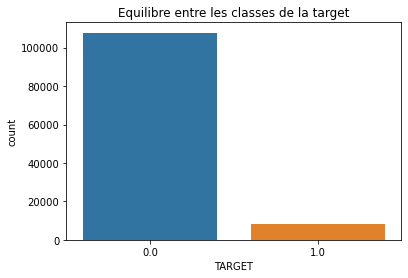

In [4]:
# Visualisation de l'équilibre entre les classes de la target
sns.countplot(data = df, x='TARGET')
plt.title('Equilibre entre les classes de la target')

clients_normaux = round(df['TARGET'].value_counts()[0])
clients_complexes = round(df['TARGET'].value_counts()[1])
clients_normaux_p = round(df['TARGET'].value_counts()[0]/len(df) * 100,2)
clients_complexes_p = round(df['TARGET'].value_counts()[1]/len(df) * 100,2)
imb_ratio = (df['TARGET'].value_counts()[0]/len(df))/(df['TARGET'].value_counts()[1]/len(df))

print(f"Clients normaux : {clients_normaux} individus, soit {clients_normaux_p} % du dataset")
print(f"Clients avec des difficultés de paiement : {clients_complexes} individus, soit {clients_complexes_p} % du dataset")
print(f'Ratio de déséquilibre: {imb_ratio}')

On constate que la target est très déséquilibrée (ratio de 12.8). 

Il sera impératif de rééquilibrer la target avant la modélisation.

In [5]:
# Retrait des nan de la target
df = df[df.TARGET.notna()]

# Sépare la target du df
y = df['TARGET']
X = df.drop(['TARGET'],axis = 1)

## Train test split

In [6]:
# Sépare le df en train et test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state=12)

# Redimnensionner la target
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

print("Dimension de X_train{} et X_test {}.".format(X_train.shape, X_test.shape))
print("Dimension de y_train {} et y_test {}.".format(y_train.shape, y_test.shape))

Dimension de X_train(81327, 298) et X_test (34855, 298).
Dimension de y_train (81327, 1) et y_test (34855, 1).


## Imputation des nan

In [7]:
# Les nan étant faibles, simple imputer est utilisé car plus rapide que  KNNImputer
imputer = SimpleImputer(strategy='median')
X_train_impt = imputer.fit_transform(X_train)

In [8]:
# Sur le test set, utilisation de .transform et non de fit_transform pour éviter le dataleakage
X_test_impt = imputer.transform(X_test)

## Création d'un benchmark

In [ ]:
# Utilisation d'un Dummy Classifier utilisé comme benchmark pour comparer les modèles
dummy = DummyClassifier()
dummy.fit(X_train_impt, y_train)

In [ ]:
# Prédiction sur le test set
dum_pred = dummy.predict(X_test_impt)

# Matrice de confusion
cm = confusion_matrix(y_test, dum_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# Résultat des métriques
score_accuracy_dum_pred = accuracy_score(y_test, dum_pred)
score_recall_dum_pred = recall_score(y_test, dum_pred)
score_f1_dum_pred = f1_score(y_test, dum_pred) 
score_roc_auc_dum_pred = roc_auc_score(y_test, dum_pred) 

print('La précision est :', score_accuracy_dum_pred)
print('Le rappel est :', score_recall_dum_pred)
print('Le score f1 est :', score_f1_dum_pred)
print('Le ROC AUC est :', score_roc_auc_dum_pred)

# Visualisation des résultats
tpr,fpr, thresholds= roc_curve(dum_pred, y_test)
plt.plot([0,1],"k--")
plt.plot(fpr,tpr,label="Dummy Classifier")
plt.xlabel("Taux de Faux Positif")
plt.ylabel("Taux de Vrai Positif")
plt.title("Dummy Classifier")
plt.show()

# 2. MODELISATION

#### Resampling 
Les méthodes basiques de rééchantillonage causent de la perte d'informations ou de l'overfitting. Nous allons donc utiliser des techniques plus avancées qui ne retirent pas d'exemples aléatoirement. Nous allons regrouper les données, puis nous retirons des échantillons en utilisant la méthode des plus proches voisins avec EditedNearrestNeighours.

#### Scaling 
Pour la mise à l'échelle nous allons tester Standardscaler, RobustScaler et QuantileTransformer.

#### Algorithme de classification 
Nous allons tester 4 algorithmes de classification différents : regression logistique, random forest, XGBoost et Perceptron multicouche (MLP Classifier). Nous allons commencer par les tester sans, puis avec une optimisation des hyperparamêtres.

## Grid Search et Pipeline

In [37]:
# Initialise les estimateurs (algorithmes de classification)
clf1 = LogisticRegression(max_iter=10000)
clf2 = RandomForestClassifier()
clf3 = XGBClassifier()
clf4 = MLPClassifier()

# Création des pipelines 
pipeline_lr = Pipeline([('sampling', EditedNearestNeighbours()),
                        ('scale', StandardScaler()),
                        ('classifier', clf1)])

pipeline_rfc = Pipeline([('sampling', EditedNearestNeighbours()),
                         ('scale', StandardScaler()),
                         ('classifier', clf2)])

pipeline_xgb = Pipeline([('sampling', EditedNearestNeighbours()),
                         ('scale', StandardScaler()),
                         ('classifier', clf3)])

pipeline_mlp =Pipeline([('sampling', EditedNearestNeighbours()),
                        ('scale',StandardScaler()),
                         ('classifier', clf4)])


# Variables pour les modèles avec resampling  
param_np_1 = {'sampling__n_neighbors' : range(15, 30, 2,),
             'sampling__sampling_strategy' : ['auto', 'majority']} 

param_np_2 = {'sampling__n_neighbors' : range(15, 30, 2,),
             'sampling__sampling_strategy' : ['auto', 'majority']}

param_np_3 = {'sampling__n_neighbors' : range(15, 30, 2,),
             'sampling__sampling_strategy' : ['auto', 'majority']}

param_np_4 = {'sampling__n_neighbors' : range(15, 30, 2,),
             'sampling__sampling_strategy' : ['auto', 'majority']}

# Variables pour les modèles avec resampling et optimisation des hyperparamètres 
param1 = {'sampling__n_neighbors' : range(15, 30, 2,),
          'sampling__sampling_strategy' : ['auto', 'majority'],
          'classifier__C' : [5, 10, 15, 20],
          'classifier__penalty': ['l2'],
          'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear']}

param2 = {'sampling__n_neighbors' : range(15, 30, 2,),
          'sampling__sampling_strategy' : ['auto', 'majority'],
          'classifier__n_estimators' : [75, 100, 125],
          'classifier__max_depth' : [15, 20, 25]}

param3 = {'sampling__n_neighbors' : range(15, 30, 2,),
          'sampling__sampling_strategy' : ['auto', 'majority'],
          'classifier__learning_rate' : [0.05, 0.1, 0.15], 
          'classifier__max_depth' : [6, 8, 10]}

param4 = {'sampling__n_neighbors' : range(15, 30, 2,),
          'sampling__sampling_strategy' : ['auto', 'majority'],
          'classifier__hidden_layer_sizes' : [(10,20,30), (30, 30, 30), (150, 100,50)],
          'classifier__activation' : ['tanh', 'logistic'],
          'classifier__solver' : ['adam', 'sgd',],
          'classifier__alpha' : [0.001, 0.01, 0.1]}

## 2.1 Modélisation sans optimisation des hyperparamêtres

### Regression Logistique

In [38]:
gs_np_1 = GridSearchCV(estimator=pipeline_lr,
                   param_grid=param_np_1,
                   cv=5,
                   scoring='f1')

start_np_1 = time.time()
gs_np_1.fit(X_train_impt[:10000], y_train[:10000].ravel())
stop_np_1 = time.time()

vitesse_lr_np_1 = stop_np_1 - start_np_1
print("Durée de l'optimisation (en sec):", vitesse_lr_np_1)
print("Modèle le plus performant:", gs_np_1.best_params_)

Durée de l'optimisation (en sec): 107.74358034133911
Modèle le plus performant: {'sampling__n_neighbors': 21, 'sampling__sampling_strategy': 'auto'}


La précision est : 0.8365514273418447
Le rappel est : 0.36220472440944884
Le score f1 est : 0.23478844862323708
Le ROC AUC est : 0.6170187668653495


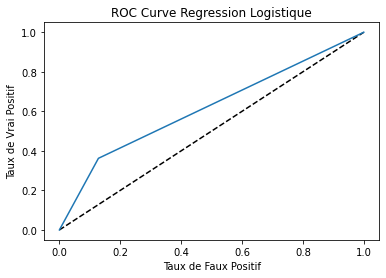

In [ ]:
# Prédictions sur le test set
pred_np_lr = gs_np_1.predict(X_test_impt)

# Enregistrement des résultats 
score_accuracy_np_lr = accuracy_score(y_test, pred_np_lr)
score_recall_np_lr = recall_score(y_test, pred_np_lr)
score_f1_np_lr = f1_score(y_test, pred_np_lr) 
score_roc_auc_np_lr = roc_auc_score(y_test, pred_np_lr) 

print('La précision est :', score_accuracy_np_lr)
print('Le rappel est :', score_recall_np_lr)
print('Le score f1 est :', score_f1_np_lr)
print('Le ROC AUC est :', score_roc_auc_np_lr)

# Visualisation de la ROC curve
tpr,fpr, thresholds = roc_curve(y_test, pred_np_lr)
plt.plot([0,1],"k--")
plt.plot(tpr,fpr,label="Logistic Regression")
plt.xlabel("Taux de Faux Positif")
plt.ylabel("Taux de Vrai Positif")
plt.title("ROC Curve Regression Logistique")
plt.show()

### Random Forest Classifier

In [ ]:
gs_np_2 = GridSearchCV(estimator=pipeline_rfc, 
                  param_grid=param_np_2, 
                  cv=5,
                  scoring='f1')

start_np_2 = time.time()
gs_np_2.fit(X_train_impt[:10000], y_train[:10000].ravel())
stop_np_2 = time.time()

vitesse_rfc_np_2 = stop_np_2-start_np_2
print("Durée de l'optimisation (en sec):", vitesse_rfc_np_2)
print("Modèle le plus performant:", gs_np_2.best_params_)

Durée de l'optimisation (en sec): 146.6551434993744
Modèle le plus performant: {'sampling__n_neighbors': 27, 'sampling__sampling_strategy': 'auto'}


La précision est : 0.7849662889112036
Le rappel est : 0.4388727724823871
Le score f1 est : 0.22032664100696975
Le ROC AUC est : 0.6247905567608902


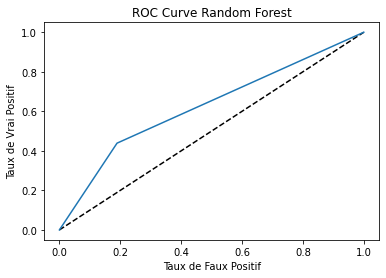

In [ ]:
# Prédictions sur le test set
pred_np_rfc = gs_np_2.predict(X_test_impt)

# Scores des métriques 
score_accuracy_np_rf = accuracy_score(y_test, pred_np_rfc)
score_recall_np_rf = recall_score(y_test, pred_np_rfc)  
score_f1_np_rf = f1_score(y_test, pred_np_rfc) 
score_roc_auc_np_rf = roc_auc_score(y_test, pred_np_rfc) 

print('La précision est :', score_accuracy_np_rf)
print('Le rappel est :', score_recall_np_rf)
print('Le score f1 est :', score_f1_np_rf)
print('Le ROC AUC est :', score_roc_auc_np_rf)

# Visualisation de la roc curve
tpr,fpr, thresholds= roc_curve(y_test, pred_np_rfc)
plt.plot([0,1],"k--")
plt.plot(tpr, fpr, label="roc_curve")
plt.xlabel("Taux de Faux Positif")
plt.ylabel("Taux de Vrai Positif")
plt.title("ROC Curve Random Forest")
plt.show()

### XGBoost Classifier

In [ ]:
gs_np_3 = GridSearchCV(estimator=pipeline_xgb, 
                  param_grid=param_np_3, 
                  cv=5,
                  scoring='f1')

start_np_3 = time.time()
gs_np_3.fit(X_train_impt[:10000], y_train[:10000].ravel())
stop_np_3 = time.time()

vitesse_xgb_np_3 = stop_np_3-start_np_3
print("Durée de l'optimisation (en sec):", vitesse_xgb_np_3)
print("Modèle le plus performant:", gs_np_3.best_params_)

[21:47:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:48:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Durée de l'optimisation (en sec): 146.42537641525269
Modèle le plus performant: {'sampling__n_neighbors': 19, 'sampling__sampling_strategy': 'auto'}


La précision est : 0.8320757423612107
Le rappel est : 0.369664318276005
Le score f1 est : 0.23359958098729866
Le ROC AUC est : 0.6180668549027518


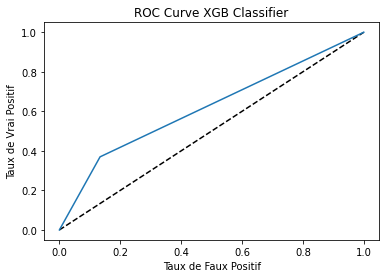

In [ ]:
# Prédictions sur le test set
pred_np_xgb = gs_np_3.predict(X_test_impt)

# Scores des métriques 
score_accuracy_np_xgb = accuracy_score(y_test, pred_np_xgb)
score_recall_np_xgb = recall_score(y_test, pred_np_xgb)                                                                                         
score_f1_np_xgb = f1_score(y_test, pred_np_xgb) 
score_roc_auc_np_xgb = roc_auc_score(y_test, pred_np_xgb) 

print('La précision est :', score_accuracy_np_xgb)
print('Le rappel est :', score_recall_np_xgb)
print('Le score f1 est :', score_f1_np_xgb)
print('Le ROC AUC est :', score_roc_auc_np_xgb)

# Visualisation de la roc curve
tpr,fpr, thresholds= roc_curve(y_test, pred_np_xgb)
plt.plot([0,1],"k--")
plt.plot(tpr, fpr, label="XGB Classifier")
plt.xlabel("Taux de Faux Positif")
plt.ylabel("Taux de Vrai Positif")
plt.title("ROC Curve XGB Classifier")
plt.show()

### MLP Classifier

In [ ]:
gs_np_4 = GridSearchCV(estimator=pipeline_mlp, 
                  param_grid=param_np_4, 
                  cv=5, 
                  scoring='f1')

start_np_4 = time.time()
gs_np_4.fit(X_train_impt[:10000], y_train[:10000].ravel())
stop_np_4 = time.time()

vitesse_mlp_np_4 = stop_np_4-start_np_4
print("Durée de l'optimisation (en sec):", vitesse_mlp_np_4)
print("Modèle le plus performant:", gs_np_4.best_params_)

Durée de l'optimisation (en sec): 258.1871542930603
Modèle le plus performant: {'sampling__n_neighbors': 21, 'sampling__sampling_strategy': 'majority'}


La précision est : 0.7850810500645532
Le rappel est : 0.4123497720679652
Le score f1 est : 0.20989347115283197
Le ROC AUC est : 0.6125770807198836


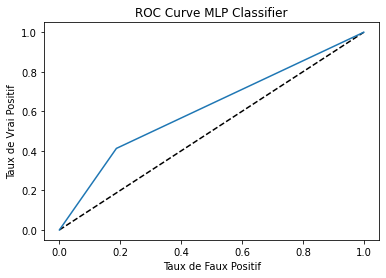

In [ ]:
# Prédictions sur le test set
pred_np_mlp = gs_np_4.predict(X_test_impt)

# Scores des métriques 
score_accuracy_np_mlp = accuracy_score(y_test, pred_np_mlp)
score_recall_np_mlp = recall_score(y_test, pred_np_mlp)                                                                                         
score_f1_np_mlp = f1_score(y_test, pred_np_mlp) 
score_roc_auc_np_mlp = roc_auc_score(y_test, pred_np_mlp) 


print('La précision est :', score_accuracy_np_mlp)
print('Le rappel est :', score_recall_np_mlp)
print('Le score f1 est :', score_f1_np_mlp)
print('Le ROC AUC est :', score_roc_auc_np_mlp)

# Visualisation de la roc curve
tpr,fpr, thresholds= roc_curve(y_test, pred_np_mlp)
plt.plot([0,1],"k--")
plt.plot(tpr, fpr, label="MPL Classifier")
plt.xlabel("Taux de Faux Positif")
plt.ylabel("Taux de Vrai Positif")
plt.title("ROC Curve MLP Classifier")
plt.show()

## 2.2 Modélisation avec optimisation des hyperparamêtres

### Regression Logistique

In [ ]:
gs1 = GridSearchCV(estimator=pipeline_lr,
                   param_grid=param1,
                   cv=5,
                   scoring='f1')

start1 = time.time()
gs1.fit(X_train_impt[:10000], y_train[:10000].ravel())
stop1 = time.time()

vitesse_lr = stop1 - start1
print("Durée de l'optimisation (en sec):", vitesse_lr)
print("Modèle le plus performant:", gs1.best_params_)

Durée de l'optimisation (en sec): 1490.2028739452362
Modèle le plus performant: {'classifier__C': 5, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg', 'sampling__n_neighbors': 21, 'sampling__sampling_strategy': 'auto'}


In [ ]:
# Affichage des métriques
result = pd.DataFrame(gs1.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,param_classifier__solver,param_sampling__n_neighbors,param_sampling__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,1.340946,0.008567,0.004595,0.000793,5,l2,newton-cg,21,auto,"{'classifier__C': 5, 'classifier__penalty': 'l...",0.230631,0.262745,0.258182,0.246046,0.231579,0.245836,0.013212,1
7,1.311848,0.022602,0.004787,0.000399,5,l2,newton-cg,21,majority,"{'classifier__C': 5, 'classifier__penalty': 'l...",0.230631,0.262745,0.258182,0.246046,0.231579,0.245836,0.013212,1
38,1.683323,0.069680,0.004166,0.000411,5,l2,liblinear,21,auto,"{'classifier__C': 5, 'classifier__penalty': 'l...",0.230216,0.262745,0.258182,0.246046,0.231579,0.245753,0.013309,3
39,1.668957,0.066485,0.004369,0.000478,5,l2,liblinear,21,majority,"{'classifier__C': 5, 'classifier__penalty': 'l...",0.230216,0.262745,0.258182,0.246046,0.231579,0.245753,0.013309,3
54,1.335018,0.030555,0.004596,0.000495,10,l2,newton-cg,21,auto,"{'classifier__C': 10, 'classifier__penalty': '...",0.229803,0.262548,0.258652,0.245614,0.230769,0.245477,0.013616,5


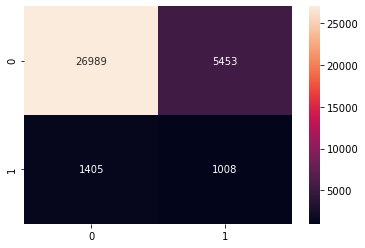

In [ ]:
# Prédictions sur le test set
pred_lr = gs1.predict(X_test_impt)

# Matrice de confusion
cm = confusion_matrix(y_test, pred_lr)
f = sns.heatmap(cm, annot=True, fmt='d')

La précision est : 0.803242002582126
Le rappel est : 0.4177372565271446
Le score f1 est : 0.22718052738336714
Le ROC AUC est : 0.624826337406042


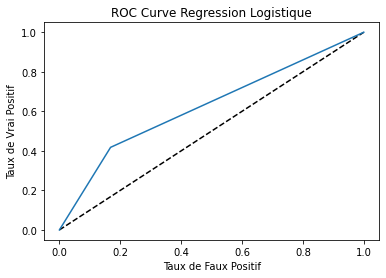

In [ ]:
# Enregistrement des résultats 
score_accuracy_lr = accuracy_score(y_test, pred_lr)
score_recall_lr = recall_score(y_test, pred_lr)
score_f1_lr = f1_score(y_test, pred_lr) 
score_roc_auc_lr = roc_auc_score(y_test, pred_lr) 

print('La précision est :', score_accuracy_lr)
print('Le rappel est :', score_recall_lr)
print('Le score f1 est :', score_f1_lr)
print('Le ROC AUC est :', score_roc_auc_lr)

# Visualisation de la ROC curve
tpr,fpr, thresholds = roc_curve(y_test, pred_lr)
plt.plot([0,1],"k--")
plt.plot(tpr,fpr,label="Logistic Regression")
plt.xlabel("Taux de Faux Positif")
plt.ylabel("Taux de Vrai Positif")
plt.title("ROC Curve Regression Logistique")
plt.show()

### Random Forest Classifier

In [ ]:
gs2 = GridSearchCV(estimator=pipeline_rfc, 
                  param_grid=param2, 
                  cv=5,
                  scoring='f1')

start2 = time.time()
gs2.fit(X_train_impt[:10000], y_train[:10000].ravel())
stop2 = time.time()

vitesse_rfc = stop2-start2
print("Durée de l'optimisation (en sec):", vitesse_rfc)
print("Modèle le plus performant:", gs2.best_params_)

Durée de l'optimisation (en sec): 1281.2431950569153
Modèle le plus performant: {'classifier__max_depth': 20, 'classifier__n_estimators': 125, 'sampling__n_neighbors': 25, 'sampling__sampling_strategy': 'majority'}


In [ ]:
# Affichage des métriques
result = pd.DataFrame(gs2.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__n_estimators,param_sampling__n_neighbors,param_sampling__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
91,1.798193,0.043331,0.047872,0.002360,20,125,25,majority,"{'classifier__max_depth': 20, 'classifier__n_e...",0.222615,0.245000,0.264642,0.259690,0.230599,0.244509,0.016180,1
76,1.619870,0.025571,0.038502,0.001351,20,100,27,auto,"{'classifier__max_depth': 20, 'classifier__n_e...",0.216718,0.256842,0.252595,0.251240,0.229391,0.241357,0.015582,2
27,1.563420,0.023383,0.037897,0.000890,15,100,25,majority,"{'classifier__max_depth': 15, 'classifier__n_e...",0.218182,0.245333,0.261242,0.273092,0.205689,0.240708,0.025399,3
90,1.759899,0.032643,0.046470,0.000496,20,125,25,auto,"{'classifier__max_depth': 20, 'classifier__n_e...",0.214936,0.220049,0.242424,0.281124,0.241379,0.239983,0.023346,4
141,1.735750,0.077649,0.047081,0.001161,25,125,27,majority,"{'classifier__max_depth': 25, 'classifier__n_e...",0.211800,0.254697,0.243568,0.269294,0.219424,0.239757,0.021472,5


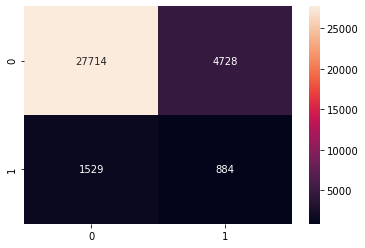

In [ ]:
# Prédictions sur le test set
pred_rfc = gs2.predict(X_test_impt)

# Matrice de confusion
cm = confusion_matrix(y_test, pred_rfc)
f = sns.heatmap(cm, annot=True, fmt='d')

La précision est : 0.820484865872902
Le rappel est : 0.36634894322420225
Le score f1 est : 0.22031152647975077
Le ROC AUC est : 0.6103059678207196


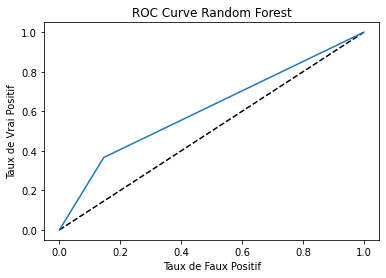

In [ ]:
# Scores des métriques 
score_accuracy_rf = accuracy_score(y_test, pred_rfc)
score_recall_rf = recall_score(y_test, pred_rfc)  
score_f1_rf = f1_score(y_test, pred_rfc) 
score_roc_auc_rf = roc_auc_score(y_test, pred_rfc) 

print('La précision est :', score_accuracy_rf)
print('Le rappel est :', score_recall_rf)
print('Le score f1 est :', score_f1_rf)
print('Le ROC AUC est :', score_roc_auc_rf)

# Visualisation de la roc curve
tpr,fpr, thresholds= roc_curve(y_test, pred_rfc)
plt.plot([0,1],"k--")
plt.plot(tpr, fpr, label="roc_curve")
plt.xlabel("Taux de Faux Positif")
plt.ylabel("Taux de Vrai Positif")
plt.title("ROC Curve Random Forest")
plt.show()

### XGBoost Classifier

In [ ]:
gs3 = GridSearchCV(estimator=pipeline_xgb, 
                  param_grid=param3, 
                  cv=5,
                  scoring='f1')

start3 = time.time()
gs3.fit(X_train_impt[:10000], y_train[:10000].ravel())
stop3 = time.time()

vitesse_xgb = stop3-start3
print("Durée de l'optimisation (en sec):", vitesse_xgb)
print("Modèle le plus performant:", gs3.best_params_)

[22:59:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:00:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:00:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:00:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:00:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:01:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:04:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:05:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:06:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:07:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:07:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:07:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:08:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:08:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:08:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:08:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:09:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:11:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:12:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:17:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:18:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:19:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:21:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:24:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:25:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:26:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
# Affichage des métriques
result = pd.DataFrame(gs3.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_sampling__n_neighbors,param_sampling__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
54,2.252578,0.110819,0.014162,0.000746,0.1,6,21,auto,"{'classifier__learning_rate': 0.1, 'classifier...",0.256121,0.251082,0.268132,0.281250,0.256198,0.262557,0.010900,1
55,2.207697,0.070909,0.013763,0.001323,0.1,6,21,majority,"{'classifier__learning_rate': 0.1, 'classifier...",0.256121,0.251082,0.268132,0.281250,0.256198,0.262557,0.010900,1
36,2.706373,0.026886,0.010372,0.000798,0.05,10,19,auto,"{'classifier__learning_rate': 0.05, 'classifie...",0.242563,0.256410,0.309582,0.245614,0.251816,0.261197,0.024666,3
37,2.949914,0.160769,0.011768,0.001466,0.05,10,19,majority,"{'classifier__learning_rate': 0.05, 'classifie...",0.242563,0.256410,0.309582,0.245614,0.251816,0.261197,0.024666,3
8,2.030135,0.140843,0.013364,0.001493,0.05,6,23,auto,"{'classifier__learning_rate': 0.05, 'classifie...",0.236301,0.261386,0.296593,0.262697,0.244000,0.260196,0.020812,5


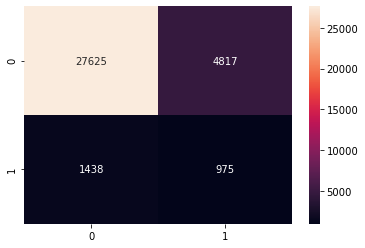

In [ ]:
# Prédictions sur le test set
pred_xgb = gs3.predict(X_test_impt)

# Matrice de confusion
cm = confusion_matrix(y_test, pred_xgb)
f = sns.heatmap(cm, annot=True, fmt='d')

La précision est : 0.8205422464495769
Le rappel est : 0.4040613344384584
Le score f1 est : 0.23765996343692872
Le ROC AUC est : 0.6277904847397272


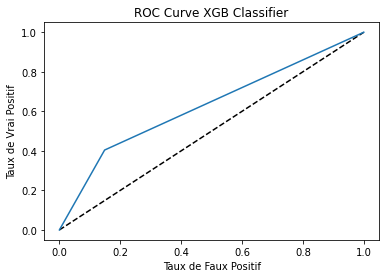

In [ ]:
# Scores des métriques 
score_accuracy_xgb = accuracy_score(y_test, pred_xgb)
score_recall_xgb = recall_score(y_test, pred_xgb)                                                                                         
score_f1_xgb = f1_score(y_test, pred_xgb) 
score_roc_auc_xgb = roc_auc_score(y_test, pred_xgb) 

print('La précision est :', score_accuracy_xgb)
print('Le rappel est :', score_recall_xgb)
print('Le score f1 est :', score_f1_xgb)
print('Le ROC AUC est :', score_roc_auc_xgb)

# Visualisation de la roc curve
tpr,fpr, thresholds= roc_curve(y_test, pred_xgb)
plt.plot([0,1],"k--")
plt.plot(tpr, fpr, label="XGB Classifier")
plt.xlabel("Taux de Faux Positif")
plt.ylabel("Taux de Vrai Positif")
plt.title("ROC Curve XGB Classifier")
plt.show()

### MLP Classifier

In [ ]:
gs4 = GridSearchCV(estimator=pipeline_mlp, 
                  param_grid=param4, 
                  cv=5, 
                  scoring='f1')

start4 = time.time()
gs4.fit(X_train_impt[:3500], y_train[:3500].ravel())
stop4 = time.time()

vitesse_mlp = stop4-start4
print("Durée de l'optimisation (en sec):", vitesse_mlp)
print("Modèle le plus performant:", gs4.best_params_)

Durée de l'optimisation (en sec): 3325.7250583171844
Modèle le plus performant: {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (30, 30, 30), 'classifier__solver': 'sgd', 'sampling__n_neighbors': 17, 'sampling__sampling_strategy': 'auto'}


In [ ]:
# Affichage des métriques
result = pd.DataFrame(gs4.cv_results_).dropna()
result.sort_values('mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__activation,param_classifier__alpha,param_classifier__hidden_layer_sizes,param_classifier__solver,param_sampling__n_neighbors,param_sampling__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
146,1.626824,0.152830,0.005385,0.001017,tanh,0.01,"(30, 30, 30)",sgd,17,auto,"{'classifier__activation': 'tanh', 'classifier...",0.162162,0.231293,0.233766,0.270968,0.283784,0.236394,0.042390,1
49,1.359965,0.027244,0.003200,0.000402,tanh,0.001,"(30, 30, 30)",sgd,15,majority,"{'classifier__activation': 'tanh', 'classifier...",0.191781,0.175676,0.285714,0.307692,0.190476,0.230268,0.054980,2
179,3.289194,0.294075,0.008577,0.001353,tanh,0.01,"(150, 100, 50)",sgd,17,majority,"{'classifier__activation': 'tanh', 'classifier...",0.213333,0.152941,0.228916,0.288889,0.240506,0.224917,0.043968,3
274,3.386554,0.149565,0.008377,0.001352,tanh,0.1,"(150, 100, 50)",sgd,17,auto,"{'classifier__activation': 'tanh', 'classifier...",0.238411,0.189873,0.233766,0.250000,0.209150,0.224240,0.021743,4
53,1.245471,0.108127,0.003989,0.000631,tanh,0.001,"(30, 30, 30)",sgd,19,majority,"{'classifier__activation': 'tanh', 'classifier...",0.198675,0.204301,0.227027,0.261364,0.227273,0.223728,0.022113,5


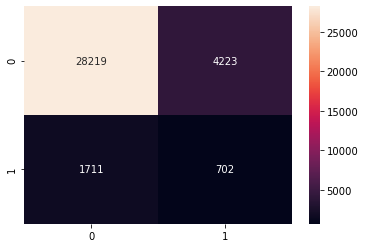

In [ ]:
# Prédictions sur le test set
pred_mlp = gs4.predict(X_test_impt)

# Matrice de confusion
cm = confusion_matrix(y_test, pred_mlp)
f = sns.heatmap(cm, annot=True, fmt='d')

La précision est : 0.8297518290058815
Le rappel est : 0.29092416079569
Le score f1 est : 0.19133278822567457
Le ROC AUC est : 0.5803766972525395


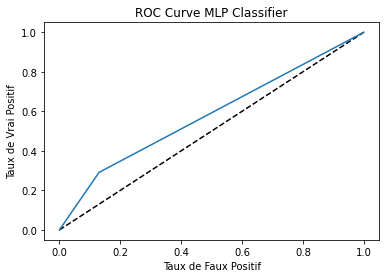

In [ ]:
# Scores des métriques 
score_accuracy_mlp = accuracy_score(y_test, pred_mlp)
score_recall_mlp = recall_score(y_test, pred_mlp)                                                                                         
score_f1_mlp = f1_score(y_test, pred_mlp) 
score_roc_auc_mlp = roc_auc_score(y_test, pred_mlp) 


print('La précision est :', score_accuracy_mlp)
print('Le rappel est :', score_recall_mlp)
print('Le score f1 est :', score_f1_mlp)
print('Le ROC AUC est :', score_roc_auc_mlp)

# Visualisation de la roc curve
tpr,fpr, thresholds= roc_curve(y_test, pred_mlp)
plt.plot([0,1],"k--")
plt.plot(tpr, fpr, label="MPL Classifier")
plt.xlabel("Taux de Faux Positif")
plt.ylabel("Taux de Vrai Positif")
plt.title("ROC Curve MLP Classifier")
plt.show()

## 2.3 Comparatif des modèles (metriques et vitesse)

### Modèles sans optimisation des hyperparamêtres

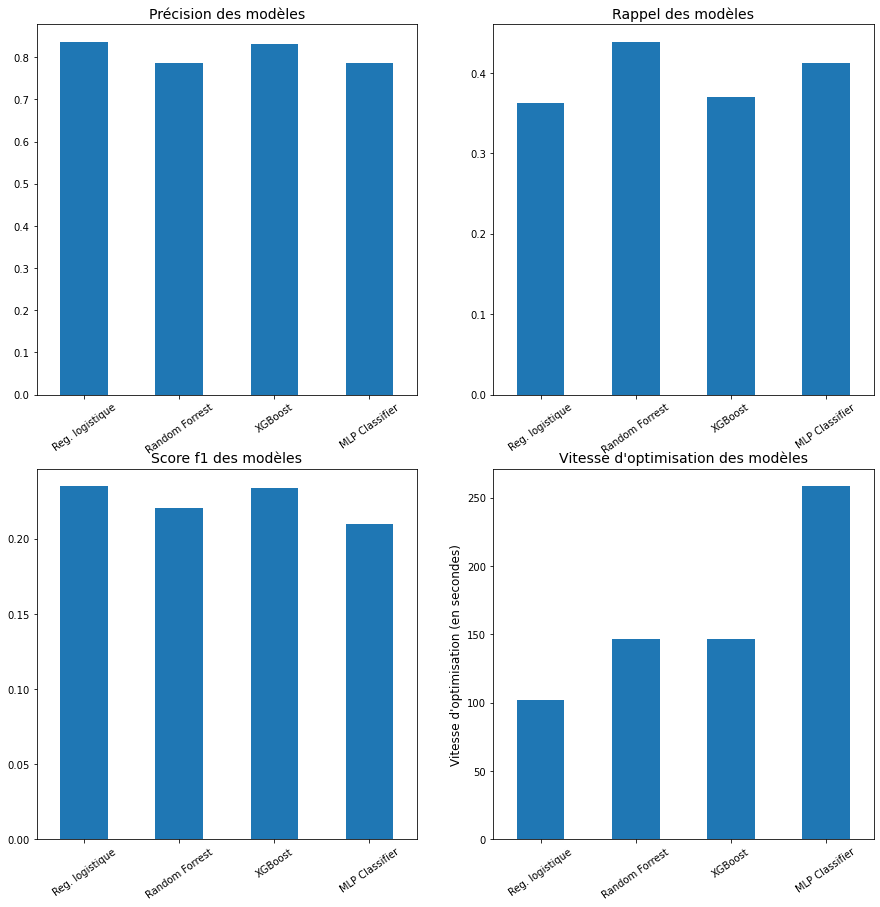

In [ ]:
plt.figure(figsize=(15,15))

# Métriques des modèles
plt.subplot(2, 2, 1)
resultats_precision = pd.Series([score_accuracy_np_lr, score_accuracy_np_rf , score_accuracy_np_xgb, score_accuracy_np_mlp], 
                        index=["Reg. logistique", "Random Forrest", "XGBoost", "MLP Classifier"])

resultats_precision.plot.bar()
plt.title("Précision des modèles", fontsize=14)
degrees = 35
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2, 2, 2)
resultats_rappel = pd.Series([score_recall_np_lr, score_recall_np_rf , score_recall_np_xgb, score_recall_np_mlp], 
                        index=["Reg. logistique", "Random Forrest", "XGBoost", "MLP Classifier"])

resultats_rappel.plot.bar()
plt.title("Rappel des modèles", fontsize=14)
degrees = 35
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2, 2, 3)
resultats_f1 = pd.Series([score_f1_np_lr, score_f1_np_rf , score_f1_np_xgb, score_f1_np_mlp], 
                        index=["Reg. logistique", "Random Forrest", "XGBoost", "MLP Classifier"])

resultats_f1.plot.bar()
plt.title("Score f1 des modèles", fontsize=14)
degrees = 35
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

# Vitesse d'entrainement et d'optimisation des modèles
plt.subplot(2, 2, 4)
vitesse_opt = pd.Series([vitesse_lr_np_1, vitesse_rfc_np_2, vitesse_xgb_np_3, vitesse_mlp_np_4], 
                    index=["Reg. logistique", "Random Forrest", "XGBoost", "MLP Classifier"])

vitesse_opt.plot.bar()
plt.title("Vitesse d'optimisation des modèles", fontsize=14)
plt.ylabel("Vitesse d'optimisation (en secondes)", fontsize=12)
degrees = 35
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

plt.show()

### Modèles avec optimisation des hyperparamêtres

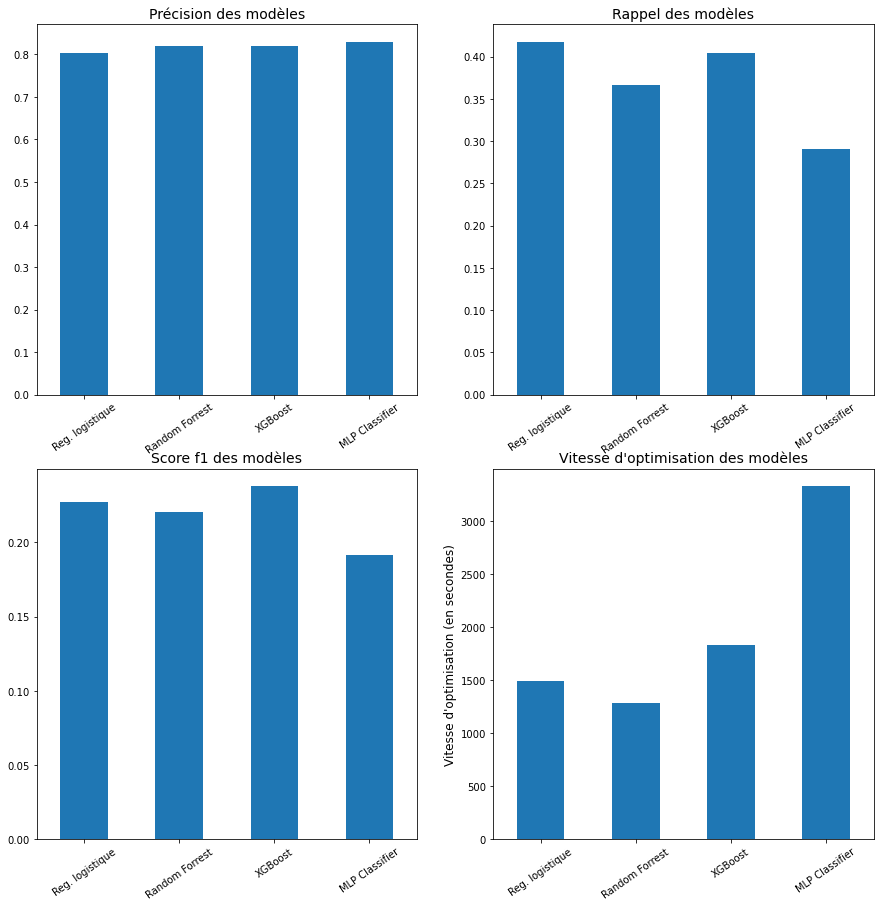

In [ ]:
plt.figure(figsize=(15,15))

# Métriques des modèles
plt.subplot(2, 2, 1)
resultats_precision = pd.Series([score_accuracy_lr, score_accuracy_rf , score_accuracy_xgb, score_accuracy_mlp], 
                        index=["Reg. logistique", "Random Forrest", "XGBoost", "MLP Classifier"])

resultats_precision.plot.bar()
plt.title("Précision des modèles", fontsize=14)
degrees = 35
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2, 2, 2)
resultats_rappel = pd.Series([score_recall_lr, score_recall_rf , score_recall_xgb, score_recall_mlp], 
                        index=["Reg. logistique", "Random Forrest", "XGBoost", "MLP Classifier"])

resultats_rappel.plot.bar()
plt.title("Rappel des modèles", fontsize=14)
degrees = 35
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2, 2, 3)
resultats_f1 = pd.Series([score_f1_lr, score_f1_rf , score_f1_xgb, score_f1_mlp], 
                        index=["Reg. logistique", "Random Forrest", "XGBoost", "MLP Classifier"])

resultats_f1.plot.bar()
plt.title("Score f1 des modèles", fontsize=14)
degrees = 35
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

# Vitesse d'entrainement et d'optimisation des modèles
plt.subplot(2, 2, 4)
vitesse_opt = pd.Series([vitesse_lr, vitesse_rfc, vitesse_xgb, vitesse_mlp], 
                    index=["Reg. logistique", "Random Forrest", "XGBoost", "MLP Classifier"])

vitesse_opt.plot.bar()
plt.title("Vitesse d'optimisation des modèles", fontsize=14)
plt.ylabel("Vitesse d'optimisation (en secondes)", fontsize=12)
degrees = 35
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

plt.show()

## 2.4 Conclusion sur la modélisation 

### Vitesse d'entrainement / d'optimisation :

Comme on pouvait s'y attendre, entraîner un modèle est beaucoup plus rapide que devoir l'optimiser. 

Malgré ce delta en faveur des modèles non optimisé, il est important de noter qu'à part le modèle basé sur un MLP, les 3 modèles ont tous mis moins de 30 minutes à optimiser leurs hyperparamètres.

Cette rapidité d'optimisation incite à sélectionner vers des modèles optimisés qui superformeront toujours des modèles non optimisés.

### Résultat des métriques :

- Le modèle avec la précision la plus élevé est le MLP (0.829)

- Le modèle avec le rappel le plus élevé est la Regression logistique (0.417)

- Le modèle avec le score f1 le plus élevé est le XGBoost classifier (0.237)

- Le modèle avec le score ROC AUC le plus élevé est le XGBoost classifier (0.627)

#### Modèle sélectionné  : XGBoost classifier

En plus d'avoir les meilleurs score F1 et ROC AUC, le XGBoost classifier se classe à la seconde place pour :

- La précision avec un score de 0.820

- Le rappel avec un score de 0.404

# 3. INTERPRETATION DU MODELE

La difficulté de connaitre le fonctionnement d'un modèle et les caractéristiques qui impactent le plus ses performances est un reproche fréquent des modèles réalisé avec du machine learning ou du deep learning. 

Pour éviter d'utiliser des modèles opaque nommés 'boite noire', il existe des outils qui permettent d'interpréter ces modèles.

In [9]:
# Sous-échantillonnage avec EditedNearestNeighbours
res = EditedNearestNeighbours(sampling_strategy = 'majority',
                              n_neighbors= 23)

# Resampler le df
X_res, y_res = res.fit_resample(X_train_impt, y_train)
y_res = pd.DataFrame(y_res) # Convetir y_res en df

# Scaling
scaler =  StandardScaler() 
X_train_scl = scaler.fit_transform(X_res)
y_train_scl = scaler.fit_transform(y_res)

y_train_scl = y_train_scl.astype(int) # Convertir y_train_scl en nombre entier

# Modelisation
xgb = XGBClassifier(learning_rate= 0.5,
                      max_depth=6)

model = xgb.fit(X_train_scl, y_train_scl, eval_metric="logloss")

# Interpretation du modèle
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

## SHAP pour interpréter le modèle retenu :
- Nous n'utiliserons pas de librairies comme Lime qui ont des bais dus à une hypothèse de non-corrélation entre features. 
- Shap sera utilisé, son modèle basé sur la théorie des jeux coopératifs étant plus proche de la réalité.

Pour résumer, les valeurs de Shapley donnent une métrique pour évaluer l'importance d'un prédicteur (caractérisque) par rapport aux autres prédicteurs. Essentiellement, ces valeurs tiennent compte de la façon dont la fonction de perte (erreur de modèle) est affectée par la connaissance ou l'ignorance de cette caractéristique prédictive. Ces valeurs indiquent également le sens de la relation (positive ou négative) entre la caractéristique prédictive et la variable cible.

## A.Interprétabilité globale
L’interprétabilité globale permet d'identifier les variables les plus importantes du modèle.

Pour cela, Shap analyse la contribution, positive ou négative, de chaque variable sur la variable cible.

Il faut souligner que si les valeurs Shap mettent en avant des corrélations, elles ne fournissent pas de causalité. Pour identifier les causalités d'autres techniques peuvent être utilisées (discontinuité de régression, différence dans les différences, modèles à effet fixes...)


### 3.1 Le diagramme à bar classique

La version classique du graphique récapitulatif montre les caractéritisques qui ont le plus d'impact sur la variable cible.

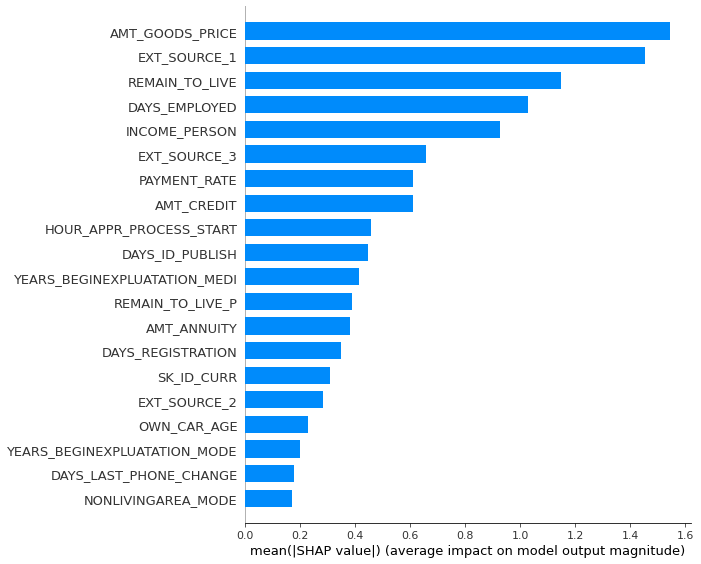

In [11]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Les features qui contribuent le plus au modèle sont 'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'AMT_CREDIT', 'DAYS_EMPLOYED' et 'EXT_SOURCE_3'.

### 3.2 Le graphique récapitulatif

Le graphique récapitulatif remplace le diagramme à barres typique de l'importance des caractéristiques. Il indique quelles caractéristiques sont les plus importantes, ainsi que leurs effets sur l'ensemble de données.

#### Comment analyser le summary plot :

*   **Importance des caractéristiques** : les variables sont classées par ordre décroissant.

*   **Impact** : l'emplacement horizontal indique si l'effet de cette valeur est associé à une prédiction supérieure ou inférieure .

*   **Valeur d'origine** : la couleur indique si cette variable est élevée (en rouge) ou faible (en bleu) pour cette observation.

*   **Corrélation** : Un niveau élevé de la teneur en « alcool » a un impact élevé et positif sur la note de qualité. Le « élevé » provient de la couleur rouge et l'impact « positif » est indiqué sur l'axe des X. De même, on dira que « l'acidité volatile » est corrélée négativement avec la variable cible.




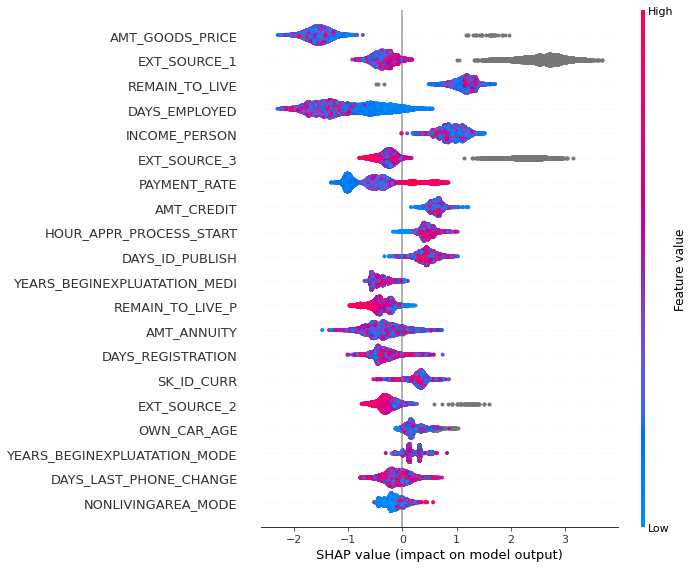

In [12]:
# Graphique récapitulatif (summary plot)
shap.summary_plot(shap_values, X_test)

On constate qu'une feature comme 'AMT_GOODS_PRICE' (prix des objets dépensés avec le prêt) à globalement une contribution négative avec la target.

A contrario la feature 'INCOME_PERSON' (revenu de l'individu) à globalement une contribution positive, et ses valeurs sont élevés.

### 3.3 Le graphique de dépendance

Alors qu'un tracé récapitulatif SHAP donne un aperçu général de chaque fonctionnalité, un tracé de dépendance SHAP montre comment la sortie du modèle varie en fonction de la valeur de la fonctionnalité. Il montre l'effet marginal qu'une ou deux variables ont sur le résultat prédit. Il indique si la relation entre la cible et la variable est linéaire, monotone ou plus complexe.

#### Comment analyser le dependence plot :

Lorsque nous voulons obtenir le diagramme de dépendance d'une caractéristique, en plus de la relation avec la target, SHAP inclut automatiquement une autre caractéristique avec laquelle elle interagit le plus. 

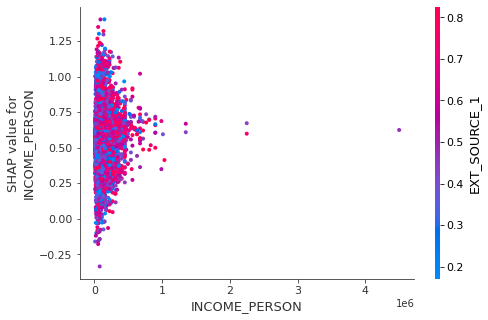

In [ ]:
# Graphique de dependance (dependence plot)
shap.dependence_plot("INCOME_PERSON", shap_values, X_test)

Par exemple ce graphique nous a montré qu'il existe une tendance approximativement monotone et positive entre les revenus et la variable cible, et que les revenus interagissent fréquemment avec la feature « EXT_SOURCE_1».

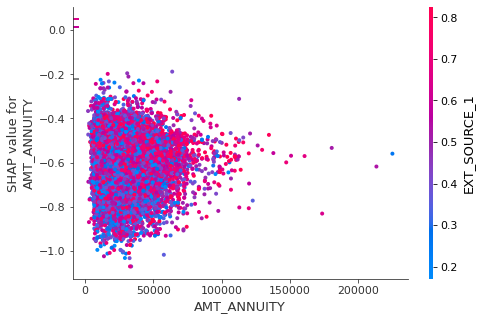

In [ ]:
shap.dependence_plot("AMT_ANNUITY", shap_values, X_test)

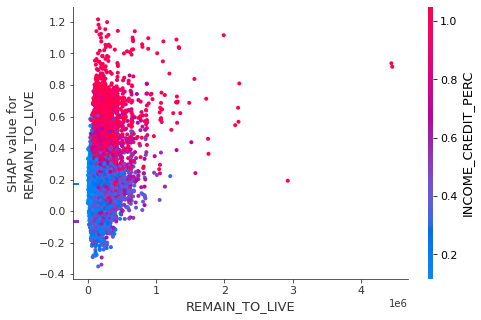

In [ ]:
shap.dependence_plot("REMAIN_TO_LIVE", shap_values, X_test)

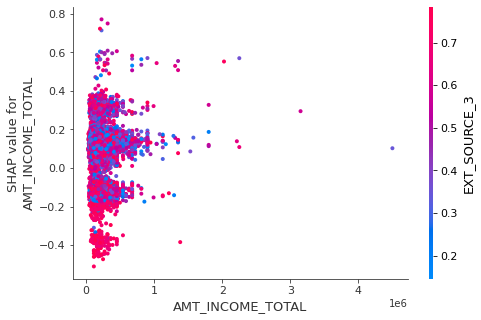

In [13]:
shap.dependence_plot("AMT_INCOME_TOTAL", shap_values, X_test)

### 3. 4 La carte thermique 

La carte thermique, appelée heatmap, classe également les caractéristiques qui contribuent le plus à la variable cible. Le classement est effectué en fonction du nombre d'individus pris en compte.

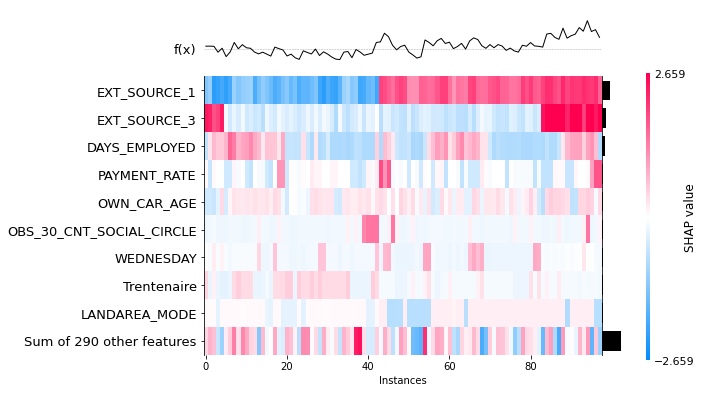

In [52]:
shap.plots.heatmap(shap_values[1:99]) # pour les 100 premières instances

## B. Interprétabilité locale
L’interprétabilité locale permet de décrypter le comportement du modèle à l’échelle d’un individu.

Shap va identifier l’impact et la contribution locale de chaque variable.

### 3. 5 Le diagramme de force individuel

Le diagramme de force individuel montre les caractéristiques qui contribuent à faire passer la sortie du modèle de la valeur de base (la sortie moyenne du modèle sur l'ensemble de données d'apprentissage que nous avons transmis) à la sortie du modèle. Les entités poussant la prédiction vers le haut sont affichées en rouge, celles poussant la prédiction vers le bas sont en bleu.

### Comment analyser le diagramme de force individuel :


*   La **valeur de sortie** (output value) est la prédiction pour cette observation.

*   **Feature** : les features et leur impact sur la valeur de sortie sont affichés.

*   La **valeur de base** (base value) : la valeur de base est la valeur qui serait prédite si nous ne connaissions aucune caractéristique pour la sortie actuelle.

*   **Rouge/bleu** : les fonctionnalités qui poussent la prédiction vers le haut (vers la droite) sont affichées en rouge, et celles qui poussent la prédiction vers le bas sont en bleu.

*   Le tracé est centré sur l'axe des abscisses à *explainer.expected_value*. Toutes les valeurs SHAP sont relatives à la valeur attendue du modèle, comme les effets d'un modèle linéaire sont relatifs à l'ordonnée à l'origine.

In [15]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:]) #pour la 1ere observation

En appliquant le diagramme de force individuel sur le 1er individu, on constate que l'ancienneté au même poste (DAYS_EMPLOYED) a un impact positif sur la note. 

L'ancienneté est de 8.29 ce qui est supérieur à la valeur de base de 0.51. Il attire donc la prédiction du coté positif.

### 3.6 Le graphique de force collective

Chaque observation a son propre diagramme de force. Si tous les diagrammes de force individuel sont combinés, pivotés de 90 degrés et empilés horizontalement, nous pouvons voir des explications pour un ensemble de données entier.

In [11]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

In [14]:
# Graphique de force collective (force plot)
shap.force_plot(explainer.expected_value, shap_values[1:99], X_test) # pour les 100 premières observations

### 3.7 Le Graphique en cascade

Le graphique en cascade permet de représenter les mêmes informations que le diagramme de force individuel, en superposant les caractéritisque en fonction de leur impact.

In [18]:
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

100%|===================| 34708/34855 [00:57<00:00]        

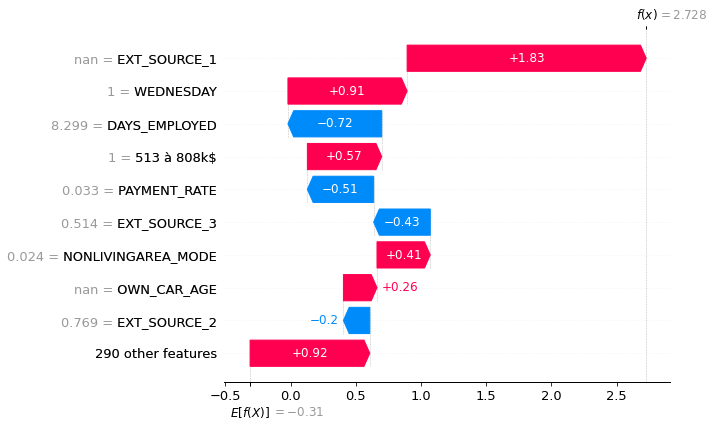

In [55]:
shap.plots.waterfall(shap_values[0])  #pour la 1ere observation

# 4. Enregistrement de la pipeline finale pour la mise en production 

In [70]:
# Pipeline finale
clf = XGBClassifier(learning_rate= 0.3,
                         max_depth=8)
pipeline_xgb_300 = Pipeline([('sampling', EditedNearestNeighbours(sampling_strategy = 'majority', n_neighbors= 23)),
                               ('scale', StandardScaler()),
                               ('classifier', clf)])

# Enregistrement de la pipeline finale pour la mise en production
joblib.dump(pipeline_xgb_300, 'xgb_300.joblib')

['xgb_300.joblib']